### Data Assimilation Project

Joseph Du Toit, Abraham Harris, Oscar Escobar

We used code from these repositories for Navier-Stokes cavity flow and particle filtering:

(Cavity Flow) : https://github.com/DrZGan/Python_CFD/blob/main/15.%20Cavity%20flow%20with%20Naiver-Stokes%20equation.ipynb

(Particle Filtering) : https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb

In [238]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import rice, rayleigh, multivariate_normal, multinomial
from tqdm import tqdm

In [239]:
nx = 41
ny = 41
nt = 500 
nit = 50
c = 1
length = 1
dx = length / (nx-1)
dy = length / (ny-1)
x = np.linspace(0,length,nx)
y = np.linspace(0,length,ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = 0.01
dt = 0.01

u = np.zeros((ny,nx))
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))
b = np.zeros((ny,nx))

print("Reynold's number =", c*length/nu)

Reynold's number = 100.0


In [240]:
def spike_noise(spike_prob, min_val, max_val):
    noise = np.random.choice([0, 1], p=[1 - spike_prob, spike_prob])
    spike = np.random.uniform(min_val, max_val)
    return noise * spike

class Submarine():
    def __init__(self, nx=nx, ny=ny, noise_type='rayleigh', scale=0.1):
        self.x = np.random.uniform(0.2, 0.8)
        self.y = np.random.uniform(0.2, 0.8)
        self.u = 0
        self.v = 0

        self.model_pos = []
        self.model_vel = []
        self.noised_pos = []
        self.noised_vel = []
        self.noise_type = noise_type
    
        self.nx = nx
        self.ny = ny
        self.u = 0
        self.v = 0

        self.scale = scale

        if noise_type == "rayleigh":
            self.noise_dist = rayleigh(scale=self.scale)
        if noise_type == "rician":
            self.noise_dist = rice(b=0.0001)
        if noise_type == "spike":
            self.noise_dist = spike_noise

        self.process_noise_dist = lambda : spike_noise(spike_prob=0.3, min_val=-0.0005, max_val=0.0005)
            
    def step(self, U, V, dt):
        self.x += self.u * dt + self.process_noise_dist()
        self.y += self.v * dt + self.process_noise_dist()

        self.u = U[int(self.y * self.ny), int(self.x * self.nx)]
        self.v = V[int(self.y * self.ny), int(self.x * self.nx)]

        self.model_pos.append([self.x, self.y])
        self.model_vel.append([self.u, self.v])
            
    def ping_noisy_signal(self):
        if self.noise_type == "spike":
            self.noised_pos.append([self.x + np.array([self.noise_dist(0.3, -0.05, 0.0005)]), 
                                    self.y + np.array([self.noise_dist(0.3, -0.05, 0.0005)])])
        else:
            self.noised_pos.append([self.x + self.noise_dist.rvs(1), 
                                    self.y + self.noise_dist.rvs(1)])
        
sub = Submarine(nx, ny, scale=1e-2, noise_type='spike')

In [241]:
class ParticleFilter():
    def __init__(self, num_particles, mean, cov=0.05*np.eye(2)):
        self.num_particles = num_particles
        self.particles = multivariate_normal.rvs(mean=mean, cov=cov, size=num_particles)
        self.weights = np.ones(num_particles) / num_particles
        self.estimates = []
        self.vars = []

    def predict(self, U, V, dt):

        for i in range(len(self.particles)):
            self.particles[i, 0] += U[int(self.particles[i, 1] * ny), int(self.particles[i, 0] * nx)] * dt
            self.particles[i, 1] += V[int(self.particles[i, 1] * ny), int(self.particles[i, 0] * nx)] * dt

    def update(self, obs):
        dists = np.linalg.norm(self.particles.T - obs, axis=0).T
        for i in range(len(self.particles)):
            self.weights[i] *= multivariate_normal.pdf(dists[i], mean=self.particles[i], cov=0.1*np.eye(2))
        
        self.weights += 1e-300
        self.weights /= np.sum(self.weights)
    
    def estimate(self):
        mean = np.average(self.particles, weights=self.weights, axis=0)
        var = np.average((self.particles-mean)**2, weights=self.weights, axis=0)
        self.estimates.append(mean)
        self.vars.append(var)

    def resample(self):
        idxs = multinomial.rvs(n=self.num_particles, p=self.weights.reshape(-1))
        self.particles = self.particles[idxs]

        self.weights = np.ones_like(self.weights) / self.num_particles

filter = ParticleFilter(num_particles=1000, mean=[sub.x, sub.y], cov=np.eye(2)*0.001)

In [242]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

def pressure_poisson_l1norm(p, dx, dy, b, l1norm_target):
    pn = np.empty_like(p)
    pn = p.copy()

    l1norm = 1
    small = 1e-8
    niter = 0
    while l1norm > l1norm_target:
        niter += 1   # count the number of iterations for convergence
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        l1norm = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
        
    return p, niter

def velocity_u_update(u, dx, dy, dt, rho, p, un, vn):
    
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                    un[1:-1, 1:-1] * dt / dx *
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                    dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                    nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
    return u

def velocity_v_update(v, dx, dy, dt, rho, p, un, vn):
    
    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                    dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    return v

def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):

    un = np.empty_like(u)
    vn = np.empty_like(v)
    pn = np.empty_like(p)
    b = np.zeros((ny, nx))
    small = 1e-8    
    pbar = tqdm(total=nt)
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        pn = p.copy()
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        #p = pressure_poisson(p, dx, dy, b)
        p, niter = pressure_poisson_l1norm(p, dx, dy, b, 1e-4)
        #print(niter)

        u = velocity_u_update(u, dx, dy, dt, rho, p, un, vn)
        v = velocity_v_update(v, dx, dy, dt, rho, p, un, vn)
        
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = c    # set velocity on cavity lid equal to c
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0

        sub.step(u, v, dt)
        filter.predict(u, v, dt)
        filter.estimate()

        if n % 20 == 0:
            sub.ping_noisy_signal()
            if n == 0:
                filter.mean = sub.noised_pos[-1]
            filter.update(sub.noised_pos[-1])
        
        if n % 100 == 0:
            filter.resample()

        pbar.set_description(f"Iteration {n}/{nt}")
        pbar.update(1)
    pbar.close()
            
        
    l1norm_u = (np.sum(np.abs(u[:]-un[:])) / (np.sum(np.abs(un[:]))+small))
    l1norm_v = (np.sum(np.abs(v[:]-vn[:])) / (np.sum(np.abs(vn[:]))+small))
    l1norm_p = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
    print("l1norm_u = ",  l1norm_u, "l1norm_v = ",  l1norm_v, "l1norm_p = ",  l1norm_p)
    return u, v, p


In [243]:
#%%timeit -r 1 -n 1
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))

# x = np.linspace(0, 2, nx)
# y = np.linspace(0, 2, ny)
# X, Y = np.meshgrid(x, y)

# # Add a vortex-like initial condition
# u = -np.sin(np.pi * Y)  # x-velocity
# v = np.sin(np.pi * X)   # y-velocity
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 1000
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

Iteration 999/1000: 100%|██████████| 1000/1000 [00:10<00:00, 98.45it/s]

l1norm_u =  2.1990346478730785e-05 l1norm_v =  3.5707074162573295e-05 l1norm_p =  9.34218062578341e-05


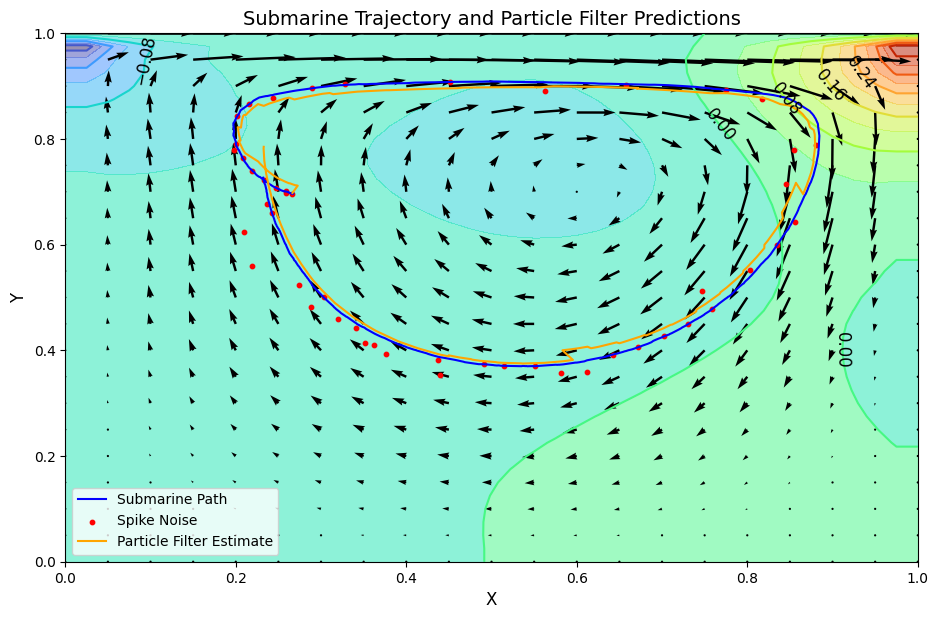

In [244]:
# Create figure and set dpi and figure size
fig = plt.figure(figsize=(11,7), dpi=100)

# Contourf plot for pressure field with colorbar
cf = plt.contourf(X, Y, p, alpha=0.5, cmap='turbo', levels=20)
# plt.colorbar(cf, label='Pressure')

# Contour plot for pressure field outlines
contour = plt.contour(X, Y, p, cmap='turbo', levels=10)
plt.clabel(contour, inline=False, fontsize=12, colors = 'black')

# Quiver plot for velocity field
quiv = plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 

# Setting labels for the x and y axes
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)

plt.plot(*zip(*sub.model_pos), color='blue', label='Submarine Path')
plt.scatter(*zip(*sub.noised_pos), color='red', s=10, label='Spike Noise')

plt.plot(*zip(*filter.estimates), color='orange', label='Particle Filter Estimate')

# Setting the title for the plot
plt.title('Submarine Trajectory and Particle Filter Predictions', fontsize=14)

# Display the plot
plt.legend()
plt.show()